# 라이브러리

In [1]:
from sklearn.metrics import f1_score
from glob import glob
import pathlib
from pathlib import Path
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pprint import pprint
import urllib.request
import csv
import numpy as np
from einops import rearrange, reduce, repeat
from torch.cuda import amp
from tqdm import tqdm
import wandb
import time
import copy
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import joblib
import gc
import os
from icecream import ic
from sklearn.model_selection import train_test_split
import gc
import cv2
import copy
import time
import random
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import timm

import json

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


from sklearn.metrics import f1_score

# CSV 파일들 불러오기

In [2]:
csvs_path = Path('./')
csvs_list = glob(str(csvs_path / '*.csv'))
csvs_list

['submit_swin_noTTA.csv',
 'submit_coat_mini_epoch45_Loss0.0005.bin.csv',
 'submit_effnetv2_epoch3_Loss0.0760.bin.csv',
 'submit_hybridswin_epoch10_Loss0.1471.bin.csv',
 'submit_swin_TTA.csv',
 'submit_effnetv2m_swin_deit_noisy(Ensemble1).csv',
 'submit_effnetv2m_swin_deit_b4ns(Ensemble1).csv',
 'submit_deit_epoch13_Loss0.0081.bin.csv',
 'submit_tf_efficientnet_b4_ns_epoch50_Loss0.0127.bin.csv',
 'submit_effnetv2m_swin_deit_b4ns512_coatmini224.csv']

In [3]:
Path(csvs_list[0]).stem

'submit_swin_noTTA'

In [4]:
csv_df = pd.DataFrame()

for csv_path in csvs_list:
    csv = pd.read_csv(csv_path)
    name = str(Path(csv_path).stem)
    data = csv['label']
    csv_df[name] = data

csv_df.head()

,submit_swin_noTTA,submit_coat_mini_epoch45_Loss0.0005.bin,submit_effnetv2_epoch3_Loss0.0760.bin,submit_hybridswin_epoch10_Loss0.1471.bin,submit_swin_TTA,submit_effnetv2m_swin_deit_noisy(Ensemble1),submit_effnetv2m_swin_deit_b4ns(Ensemble1),submit_deit_epoch13_Loss0.0081.bin,submit_tf_efficientnet_b4_ns_epoch50_Loss0.0127.bin,submit_effnetv2m_swin_deit_b4ns512_coatmini224
0,6_00_0,6_00_0,6_00_0,6_00_0,6_00_0,6_00_0,6_00_0,6_00_0,6_00_0,6_00_0
1,5_b6_1,5_b6_1,5_b6_1,5_b6_1,5_b6_1,5_b6_1,5_b6_1,5_b6_1,5_b6_1,5_b6_1
2,4_00_0,4_00_0,4_00_0,4_00_0,4_00_0,4_00_0,4_00_0,4_00_0,4_00_0,4_00_0
3,3_00_0,3_00_0,3_00_0,3_00_0,3_00_0,3_00_0,3_00_0,3_00_0,3_00_0,3_00_0
4,3_b8_1,3_b8_1,3_b8_1,3_b8_1,3_b8_1,3_b8_1,3_b8_1,3_b8_1,3_b8_1,3_b8_1


# 라벨 - 정수 파일 불러오기

In [5]:
labelAndKey = joblib.load('./labelAndKey')
labelAndKey

{'1_00_0': 0,
 '2_00_0': 1,
 '2_a5_2': 2,
 '3_00_0': 3,
 '3_a9_1': 4,
 '3_a9_2': 5,
 '3_a9_3': 6,
 '3_b3_1': 7,
 '3_b6_1': 8,
 '3_b7_1': 9,
 '3_b8_1': 10,
 '4_00_0': 11,
 '5_00_0': 12,
 '5_a7_2': 13,
 '5_b6_1': 14,
 '5_b7_1': 15,
 '5_b8_1': 16,
 '6_00_0': 17,
 '6_a11_1': 18,
 '6_a11_2': 19,
 '6_a12_1': 20,
 '6_a12_2': 21,
 '6_b4_1': 22,
 '6_b4_3': 23,
 '6_b5_1': 24}

# 정수로 변환

In [6]:
csv_df = csv_df.apply(lambda x : [labelAndKey[label] for label in x])
csv_df.head()

,submit_swin_noTTA,submit_coat_mini_epoch45_Loss0.0005.bin,submit_effnetv2_epoch3_Loss0.0760.bin,submit_hybridswin_epoch10_Loss0.1471.bin,submit_swin_TTA,submit_effnetv2m_swin_deit_noisy(Ensemble1),submit_effnetv2m_swin_deit_b4ns(Ensemble1),submit_deit_epoch13_Loss0.0081.bin,submit_tf_efficientnet_b4_ns_epoch50_Loss0.0127.bin,submit_effnetv2m_swin_deit_b4ns512_coatmini224
0,17,17,17,17,17,17,17,17,17,17
1,14,14,14,14,14,14,14,14,14,14
2,11,11,11,11,11,11,11,11,11,11
3,3,3,3,3,3,3,3,3,3,3
4,10,10,10,10,10,10,10,10,10,10


# 상관관계 그래프

In [7]:
corr_df = csv_df.corr()

In [8]:
%matplotlib inline

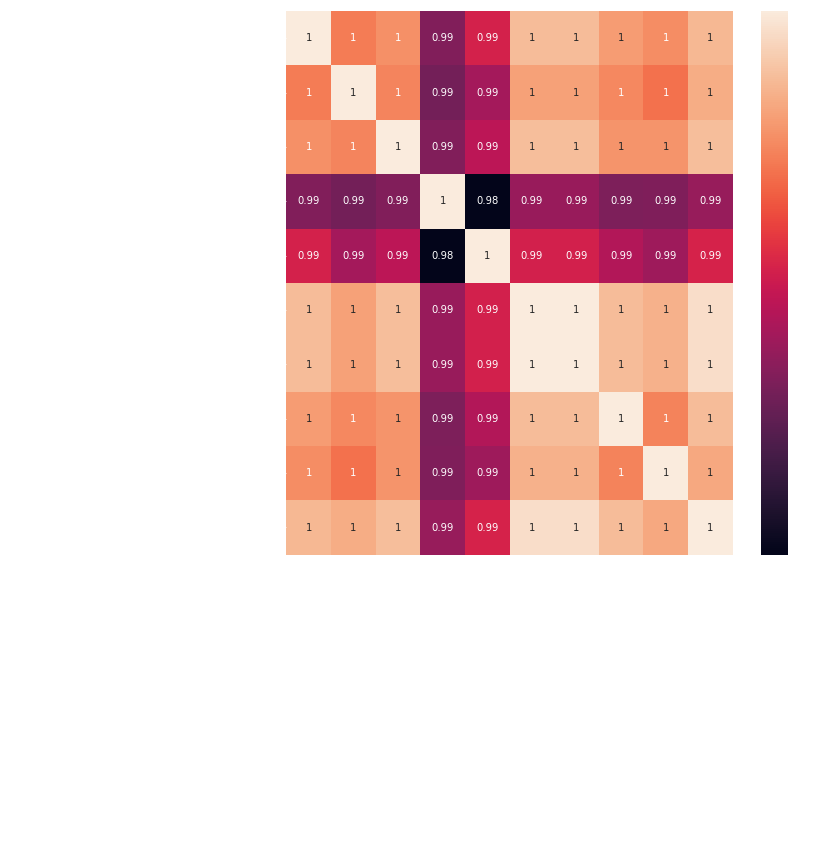

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(corr_df, annot=True)
plt.show()

- Ensemble 모델은 여러 모델들을 합한 만큼, 상관계수에서 높은 모습을 보인다
- hybridswin 모델은 다른 모든 모델들과 혼자 동떨어져있는 모습을 보여준다. Public 점수가 0.87로 매우 낮은 편에 속하는데, 이와 연관이 있음직하다
- swinTTA 모델 역시 hybridswin과 비슷하다
- 특이한 점은, Public 리더보드 점수는 swinTTA < hybridswin인데 다른 모델과의 상관관계는 hybridswin < swinTTA 이다
- 스읍 딱히 쓸모 있는 정보인가 싶다 (...)